In [2]:
#!pip install tensorflow

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.util import montage
from sklearn.decomposition import PCA
import matplotlib.patheffects as path_effects
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D

2024-06-06 00:23:37.507982: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Downloading the data

import os, requests, tarfile

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")


In [3]:
with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')


print(f'Stimuli shape: {dat["stimuli"].shape}')
print(f'Response shape: {dat["responses"].shape}')
print(f'Labels shape: {labels.shape}, {val_labels.shape}')

Stimuli shape: (1750, 128, 128)
Response shape: (1750, 8428)
Labels shape: (4, 1750), (4, 120)


In [15]:
labels[0]

array(['artifact', 'entity', 'animal', ..., 'artifact', 'artifact',
       'artifact'], dtype='<U71')

In [6]:
## print(labels[:, :4])
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


In [13]:
dat['responses_test'].shape

(120, 8428)

In [14]:
dat['stimuli_test'].shape

(120, 128, 128)

In [5]:
l = np.array(dat.keys())

In [6]:
l

array(dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names']),
      dtype=object)

In [7]:
#tasks: make multinomial logreg model and calculate cross-entropy loss

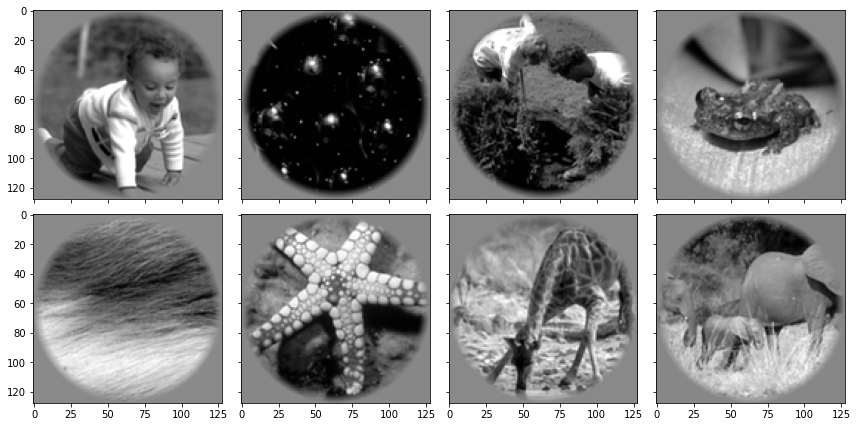

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im in zip(axs.flat, dat["stimuli"]):
  ax.imshow(im, cmap="gray")
fig.tight_layout()
fig.show()

In [9]:
dat

{'stimuli': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0.

In [25]:
dat['Categories']

KeyError: 'Categories'

## Starting from scratch

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [35]:
labels[0].shape

(1750,)

In [18]:
X = dat['responses']
y = labels[0]

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit multi log reg
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)


In [25]:
y_pred_proba.shape

(30, 3)

In [24]:
print("Predicted probabilities for each class:\n", y_pred_proba)


Predicted probabilities for each class:
 [[3.78421904e-03 8.27195988e-01 1.69019793e-01]
 [9.46723431e-01 5.32763691e-02 2.00198930e-07]
 [8.72790499e-09 1.55805533e-03 9.98441936e-01]
 [6.43257131e-03 7.92102390e-01 2.01465039e-01]
 [1.44087638e-03 7.74329961e-01 2.24229163e-01]
 [9.55776853e-01 4.42229696e-02 1.77037367e-07]
 [7.76062324e-02 9.08080232e-01 1.43135360e-02]
 [1.61394594e-04 1.55710645e-01 8.44127961e-01]
 [2.20781303e-03 7.62748161e-01 2.35044026e-01]
 [2.83150286e-02 9.45786219e-01 2.58987519e-02]
 [4.39551766e-04 2.43321406e-01 7.56239042e-01]
 [9.68315706e-01 3.16842157e-02 7.81595420e-08]
 [9.72939662e-01 2.70603050e-02 3.33724316e-08]
 [9.62103358e-01 3.78965305e-02 1.11054595e-07]
 [9.79268200e-01 2.07317350e-02 6.48271738e-08]
 [4.54059112e-03 7.12626564e-01 2.82832845e-01]
 [7.22532118e-06 2.42142067e-02 9.75778568e-01]
 [2.73303789e-02 9.47677991e-01 2.49916301e-02]
 [8.23015259e-03 8.31097094e-01 1.60672753e-01]
 [1.41934551e-05 3.59508494e-02 9.64034957e-01]

## Trying with 8 classes

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Assuming 'dat' contains the feature data and 'labels' contain the target labels
X = dat['responses']
y = labels[0]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the number of classes you want to force
num_classes = 8  # Set to the desired number of classes

# Initialize and fit multinomial logistic regression model, specifying the 'classes' parameter
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, classes=8)
model.fit(X_train, y_train)

# Predict probabilities for each class on the test set
y_pred_proba = model.predict_proba(X_test)

# Print the shape of the predicted probabilities array
print("Shape of y_pred_proba:", y_pred_proba.shape)


TypeError: __init__() got an unexpected keyword argument 'classes'

In [19]:
#calculating metric: cross entropy loss

cross_entropy_loss = log_loss(y_test, y_pred_proba)

print("Cross-Entropy Loss:", cross_entropy_loss)

ValueError: y_true and y_pred contain different number of classes 5, 8. Please provide the true labels explicitly through the labels argument. Classes found in y_true: ['animal' 'artifact' 'entity' 'fruit' 'geological formation']

In [ ]:
iris.data

In [21]:
from sklearn.datasets import load_iris


# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_proba = model.predict_proba(X_test)

# Calculate the cross-entropy loss
cross_entropy_loss = log_loss(y_test, y_pred_proba)

print("Cross-Entropy Loss:", cross_entropy_loss)


Cross-Entropy Loss: 0.1112894356088233


In [32]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [33]:
np.array(dat['roi_names'][1:])

array(['V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'LatOcc'], dtype='<U6')

In [34]:
X = dat['responses']
y = dat['roi_names']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ValueError: Found input variables with inconsistent numbers of samples: [1750, 8]

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [16]:

# Extracting relevant data
responses = dat["responses"]
labels = labels[:3,:]  # Selecting the labels predicted by the DNN

TypeError: string indices must be integers

In [17]:
labels

'tailed frog'

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Extracting relevant data
responses = dat["responses"]
labels = labels[3]  # Selecting the labels predicted by the DNN

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(responses, labels_encoded, test_size=0.2, random_state=42)

# Initialize and train the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)


KeyboardInterrupt: 

/tmp/ipykernel_115/3075017404.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)


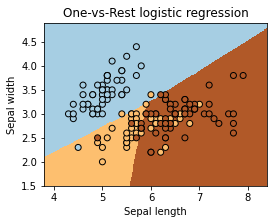

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
 
iris = load_iris()
 
# we only take the first two features for visualization
X = iris.data[:, :2] 
y = iris.target
 
clf = LogisticRegression(random_state=0,
                         multi_class='ovr',
                         solver='liblinear')
 
clf.fit(X, y)
 
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k',
            cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('One-vs-Rest logistic regression')
plt.show()